
## Automated stock trading using FinRL

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:

Action: The action space describes the allowed actions that the agent interacts with the environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s', i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively

State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so our trading agent observes many different features to better learn in an interactive environment.

Environment: Dow 30 consituents

### Install Dependencies

Install all the packages through FinRL library

In [145]:
!python --version



Python 3.11.11


In [146]:
!python -m pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-3rsxfny0
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-3rsxfny0
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 69776b349ee4e63efe3826f318aef8e5c5f59648
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-rlp_6blh/elegantrl_d66e9bdbf0d848629187c25b3b3077ee
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-rlp_6blh/elegantrl_d66e9bdbf0d848629187c25b3b3077ee
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5e828af1503098f4da046c0f12432dbd4ef8bd97
  Preparing metadata (setup.py) ... done
  Using cached joblib-1.4.2-py3-none-any.whl.metadat

In [147]:
!pip3 install pandas
!pip install numpy

In [148]:
!set PATH=%PATH%;C:\Users\natna\miniforge3\envs\finRl\Scripts


/bin/bash: line 1: C:Usersnatnaminiforge3envsfinRlScripts: command not found


In [149]:
!python -m pip install numpy==1.26.4 scipy==1.12.0 scikit-learn==1.6.1



# !python --version 1.23

### Import Packages

In [150]:
import numpy
import scipy
import sklearn
import torch
print("Numpy version:", numpy.__version__)
print("Scipy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)


Numpy version: 1.26.4
Scipy version: 1.12.0
Scikit-learn version: 1.6.1


In [151]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [152]:
# pip freeze > requirements.txt

In [153]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


Create Folders

In [154]:
import os
if not os.path.exists("./kaggle/" + config.DATA_SAVE_DIR):
    os.makedirs("./kaggle/" + config.DATA_SAVE_DIR)
if not os.path.exists("./kaggle/" + config.TRAINED_MODEL_DIR):
    os.makedirs("./kaggle/" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./kaggle/" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./kaggle/" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./kaggle/" + config.RESULTS_DIR):
    os.makedirs("./kaggle/" + config.RESULTS_DIR)

### Cleaning Alpha Vantage Data

In [155]:
df_sentiment = pd.read_csv("dow30_monthly_news_sentiment.csv")

In [156]:
df_sentiment.tail()

,ticker,published_time,title,summary,source,url,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
298965,BAC,20250422T180341,"CoreWeave Garners Praise Due To AI Growth, Nvi...",CoreWeave stock surges after Wall Street analy...,Benzinga,https://www.benzinga.com/25/04/44932684/corewe...,0.251447,Somewhat-Bullish,0.062434,0.167490,Somewhat-Bullish
298966,BAC,20250422T195651,Self-Storage REITs Score Upgrade From BofA Ana...,"Public Storage upgraded to Buy, price target r...",Benzinga,https://www.benzinga.com/analyst-ratings/upgra...,0.344110,Somewhat-Bullish,0.245339,0.308375,Somewhat-Bullish
298967,BAC,20250422T204426,What's Going On With Bank of America ( BAC ) ...,Shares of Bank of America traded higher by 3.7...,Benzinga,https://www.benzinga.com/news/25/04/44937855/w...,0.371217,Bullish,0.414559,0.195790,Somewhat-Bullish
298968,BAC,20250423T024954,Yuga Labs Demands $400K in Influencer's Crypto...,The company has accused influencer Jeremy Cahe...,Decrypt.co,https://decrypt.co/315871/yuga-labs-demands-40...,-0.085971,Neutral,0.081001,0.000000,Neutral
298969,BAC,20250423T083000,Should You Buy Nu While It's Below $12?,Investors who allocate capital to the financia...,Motley Fool,https://www.fool.com/investing/2025/04/23/shou...,0.118870,Neutral,0.059488,0.098999,Neutral


In [157]:
df_sentiment.drop(columns=["title", "summary", "source", "url"], inplace=True)

In [158]:
df_sentiment["date"] = pd.to_datetime(df_sentiment["published_time"]).dt.date
df_sentiment.drop(columns=["published_time"], inplace=True) 

In [159]:
df_sentiment.tail()

,ticker,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label,date
298965,BAC,0.251447,Somewhat-Bullish,0.062434,0.167490,Somewhat-Bullish,2025-04-22
298966,BAC,0.344110,Somewhat-Bullish,0.245339,0.308375,Somewhat-Bullish,2025-04-22
298967,BAC,0.371217,Bullish,0.414559,0.195790,Somewhat-Bullish,2025-04-22
298968,BAC,-0.085971,Neutral,0.081001,0.000000,Neutral,2025-04-23
298969,BAC,0.118870,Neutral,0.059488,0.098999,Neutral,2025-04-23


In [160]:
df_sentiment.groupby(["date", "ticker"]).agg({"ticker_sentiment_score": "mean"}).head()

ticker_sentiment_score
date       ticker                        
2022-03-01 AAPL                 -0.247750
           ABBV                  0.134635
           AMZN                  0.026019
           BAC                  -0.259570
           COST                 -0.432941

In [161]:
df_sentiment["weighted_score"] = (
    df_sentiment["ticker_sentiment_score"] * df_sentiment["ticker_relevance_score"]
)

agg_df = (
    df_sentiment
    .groupby(["date", "ticker"])
    .agg(
        raw_avg_sentiment=("ticker_sentiment_score", "mean"),
        total_relevance=("ticker_relevance_score", "sum"),
        weighted_sum=("weighted_score", "sum"),
        article_count=("ticker_sentiment_score", "count")
    )
    .reset_index()
)

# Compute final weighted average
agg_df["weighted_avg_sentiment"] = (
    agg_df["weighted_sum"] / agg_df["total_relevance"]
)


In [162]:
agg_df.sort_values(by=["date", "ticker"], inplace=True)

In [163]:
agg_df.tail()

,date,ticker,raw_avg_sentiment,total_relevance,weighted_sum,article_count,weighted_avg_sentiment
23901,2025-04-23,PEP,0.286256,0.669327,0.195546,2,0.292153
23902,2025-04-23,TSLA,0.102081,6.638020,0.702583,15,0.105842
23903,2025-04-23,V,0.098999,0.059488,0.005889,1,0.098999
23904,2025-04-23,WMT,0.141068,0.503241,0.095014,2,0.188804
23905,2025-04-23,XOM,0.069925,0.120130,0.008400,1,0.069925


In [164]:
apple = agg_df[agg_df["ticker"] == "AAPL"]

In [165]:
full_date_range = pd.date_range(start="2022-03-01", end="2025-04-23", freq='D').date
# missing_dates = full_date_range.difference(apple['date'])


In [166]:
# print("Missing dates:")
# print(missing_dates)

In [167]:
all_combinations = pd.MultiIndex.from_product(
    [agg_df['ticker'].unique(), full_date_range],
    names=['ticker', 'date']
).to_frame(index=False)

In [168]:
merged_df = pd.merge(
    all_combinations,
    agg_df,
    how='left',
    on=['ticker', 'date']
)

In [169]:
merged_df[merged_df.isnull().any(axis=1)].head(30)

,ticker,date,raw_avg_sentiment,total_relevance,weighted_sum,article_count,weighted_avg_sentiment
25,AAPL,2022-03-26,NaN,NaN,NaN,NaN,NaN
26,AAPL,2022-03-27,NaN,NaN,NaN,NaN,NaN
27,AAPL,2022-03-28,NaN,NaN,NaN,NaN,NaN
28,AAPL,2022-03-29,NaN,NaN,NaN,NaN,NaN
29,AAPL,2022-03-30,NaN,NaN,NaN,NaN,NaN
30,AAPL,2022-03-31,NaN,NaN,NaN,NaN,NaN
56,AAPL,2022-04-26,NaN,NaN,NaN,NaN,NaN
57,AAPL,2022-04-27,NaN,NaN,NaN,NaN,NaN
58,AAPL,2022-04-28,NaN,NaN,NaN,NaN,NaN
59,AAPL,2022-04-29,NaN,NaN,NaN,NaN,NaN


In [170]:
merged_df["date"] = merged_df["date"] + pd.Timedelta(days=1)

In [171]:
merged_df = merged_df.fillna(0).sort_values(by=["date", "ticker"])

In [172]:
merged_df.to_csv("dow30_news_sentiment.csv", index=False)

In [173]:
merged_df.tail()

,ticker,date,raw_avg_sentiment,total_relevance,weighted_sum,article_count,weighted_avg_sentiment
12649,TSLA,2025-04-24,0.102081,6.638020,0.702583,15.0,0.105842
28749,UNH,2025-04-24,0.000000,0.000000,0.000000,0.0,0.000000
13799,V,2025-04-24,0.098999,0.059488,0.005889,1.0,0.098999
14949,WMT,2025-04-24,0.141068,0.503241,0.095014,2.0,0.188804
16099,XOM,2025-04-24,0.069925,0.120130,0.008400,1.0,0.069925


### Download Data from Yahoo Finance

In [174]:
df_sentiment = pd.read_csv("dow30_news_sentiment.csv")
TICKERS = df_sentiment["ticker"].unique().tolist()

In [175]:
START_DATE, END_DATE ="2022-03-02", "2025-04-23"

In [176]:
from finrl import config_tickers
df = YahooDownloader(start_date = START_DATE,
                           end_date = END_DATE,
                           ticker_list = TICKERS).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (21276, 8)


### Add technical Indicators

In [177]:
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=False,
                      user_defined_feature = False).preprocess_data(df.copy())

Successfully added technical indicators


In [178]:
# df=df.sort_values(['date','tic'],ignore_index=True)
# df.index = df.date.factorize()[0]

# cov_list = []
# # look back is one year
# lookback=252
# for i in range(lookback,len(df.index.unique())):
#   data_lookback = df.loc[i-lookback:i,:]
#   price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
#   return_lookback = price_lookback.pct_change().dropna()
#   covs = return_lookback.cov().values
#   cov_list.append(covs)

# df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
# df = df.merge(df_cov, on='date')
# df = df.sort_values(['date','tic']).reset_index(drop=True)
# df.head()

In [179]:
df.tic.unique()

array(['AAPL', 'ABBV', 'ACN', 'ADBE', 'AMZN', 'AVGO', 'BAC', 'COST',
       'CRM', 'CVX', 'GOOG', 'HD', 'KO', 'LLY', 'MA', 'META', 'MSFT',
       'NVDA', 'ORCL', 'PEP', 'PG', 'TMO', 'TSLA', 'UNH', 'V', 'WMT',
       'XOM'], dtype=object)

### Merge sentiment and technical data

In [180]:
df_sentiment.head()

,ticker,date,raw_avg_sentiment,total_relevance,weighted_sum,article_count,weighted_avg_sentiment
0,AAPL,2022-03-02,-0.247750,0.062711,-0.015537,1.0,-0.247750
1,ABBV,2022-03-02,0.134635,0.799407,0.107628,1.0,0.134635
2,ACN,2022-03-02,0.000000,0.000000,0.000000,0.0,0.000000
3,ADBE,2022-03-02,0.000000,0.000000,0.000000,0.0,0.000000
4,AMZN,2022-03-02,0.026019,0.160599,0.009154,2.0,0.056996


In [181]:
df_sentiment.rename(columns = {'Date':'date', 'ticker':'tic'}, inplace = True)

In [182]:
merged_df = df.merge(df_sentiment, on=['date', 'tic'], how='inner')


In [183]:
merged_df.drop(columns=['raw_avg_sentiment', 'total_relevance', "weighted_sum","article_count" ], inplace=True)

In [184]:
merged_df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,weighted_avg_sentiment
0,2022-03-02,163.904175,167.360001,162.949997,164.389999,79724800,AAPL,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,163.904175,163.904175,-0.247750
1,2022-03-02,132.393112,151.250000,147.220001,147.699997,8247200,ABBV,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,132.393112,132.393112,0.134635
2,2022-03-02,305.032135,320.260010,312.549988,315.420013,2220800,ACN,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,305.032135,305.032135,0.000000
3,2022-03-02,471.179993,477.489990,466.040009,471.940002,2948500,ADBE,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,471.179993,471.179993,0.000000
4,2022-03-02,152.052505,152.999496,148.750000,150.848999,47334000,AMZN,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,152.052505,152.052505,0.056996


In [185]:
merged_df.to_csv("./merged_df.csv", index=False)

### Create Environment

In [186]:
df=merged_df.copy()

In [187]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,weighted_avg_sentiment
0,2022-03-02,163.904175,167.360001,162.949997,164.389999,79724800,AAPL,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,163.904175,163.904175,-0.247750
1,2022-03-02,132.393112,151.250000,147.220001,147.699997,8247200,ABBV,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,132.393112,132.393112,0.134635
2,2022-03-02,305.032135,320.260010,312.549988,315.420013,2220800,ACN,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,305.032135,305.032135,0.000000
3,2022-03-02,471.179993,477.489990,466.040009,471.940002,2948500,ADBE,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,471.179993,471.179993,0.000000
4,2022-03-02,152.052505,152.999496,148.750000,150.848999,47334000,AMZN,2,0.0,164.201068,163.282529,0.0,66.666667,100.0,152.052505,152.052505,0.056996


In [188]:
TRAIN_START_DATE = START_DATE
TRAIN_END_DATE = "2024-03-01"
TEST_START_DATE = "2024-03-01"
TEST_END_DATE = END_DATE

In [189]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TEST_START_DATE,TEST_END_DATE)

State Space and Action Space Calculation

In [190]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (len(config.INDICATORS)+1)*stock_dimension

In [191]:
print(stock_dimension)
print(state_space)

27
298


Environment Details

In [192]:
# Define transaction cost lists for buying and selling stocks
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# Explanation: 
# - `buy_cost_list` and `sell_cost_list` represent the transaction costs as a percentage for buying and selling stocks.
# - `[0.001] * stock_dimension` creates a list where each element is 0.001 (0.1% transaction fee), repeated for each stock.
# - The use of `=` assigns the same list to both `buy_cost_list` and `sell_cost_list`.

# Initialize the list to track the number of shares owned for each stock
num_stock_shares = [0] * stock_dimension
# Explanation:
# - `num_stock_shares` is a list where each element is initialized to 0, representing that no shares are owned initially.
# - `[0] * stock_dimension` ensures the list length matches the number of stocks (`stock_dimension`).

# Create a dictionary to store environment configuration parameters
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS+["weighted_avg_sentiment"],  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4  # Scaling factor for rewards to normalize them and improve learning stability.
}
# Explanation:
# - This dictionary (`env_kwargs`) encapsulates all the necessary parameters required to initialize the stock trading environment.
# - It includes configuration for portfolio management (e.g., `hmax`, `initial_amount`, `num_stock_shares`) and the structure of the RL problem (e.g., `state_space`, `action_space`).

# Initialize the stock trading environment with the training data and configuration parameters
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
# Explanation:
# - `StockTradingEnv` is a custom environment class for stock trading, compliant with OpenAI Gym standards.
# - `df=train` specifies the training data (a DataFrame containing historical stock prices and other features).
# - `**env_kwargs` unpacks the `env_kwargs` dictionary, passing each key-value pair as an argument to the environment initializer.
# - The environment simulates the stock trading process, enabling the RL agent to interact with it by observing states, taking actions, and receiving rewards.


Environment for training

In [193]:
env_train, _ = e_train_gym.get_sb_env() #get stable baseline environment for training
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [194]:
agent = DRLAgent(env = env_train)
# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = False

In [195]:
from stable_baselines3.common.logger import configure

 Implement DRL Algorithms

In [24]:
import torch

print('Current version of PyTorch: ', torch.__version__)

if torch.cuda.is_available():
  print('PyTorch can use GPUs!')
else:
  print('PyTorch cannot use GPUs.')

Current version of PyTorch:  2.6.0+cu118
PyTorch can use GPUs!


### DDPG

Training

In [296]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.001,
}
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [297]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=20000) if if_using_ddpg else None

------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 200         |
|    time_elapsed    | 9           |
|    total_timesteps | 2008        |
| train/             |             |
|    actor_loss      | 19.9        |
|    critic_loss     | 58.7        |
|    learning_rate   | 0.001       |
|    n_updates       | 1907        |
|    reward          | -0.40158615 |
------------------------------------
day: 501, episode: 1460
begin_total_asset: 1000000.00
end_total_asset: 1361358.09
total_reward: 361358.09
total_cost: 1234.90
total_trades: 6521
Sharpe: 1.031
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 200         |
|    time_elapsed    | 20          |
|    total_timesteps | 4016        |
| train/             |             |
|    actor_loss      | 18.3        |
|    critic_loss     | 122         |
|    learning_rate   | 0.00

In [305]:
trained_ddpg.save(config.TRAINED_MODEL_DIR + "/agent_ddpg_sentiment") if if_using_ddpg else None


Trading

In [298]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [299]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

hit end!


In [300]:
df_account_value.tail()

,date,account_value
281,2025-04-15,1.048584e+06
282,2025-04-16,1.034009e+06
283,2025-04-17,1.031864e+06
284,2025-04-21,1.004287e+06
285,2025-04-22,1.027266e+06


Backtesting Performance

In [301]:
df_dji = YahooDownloader(
    start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^DJI"]
).fetch_data()
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)


In [302]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.023986
Cumulative returns     0.027266
Annual volatility      0.168102
Sharpe ratio           0.225036
Calmar ratio           0.144357
Stability              0.500875
Max drawdown          -0.166160
Omega ratio            1.042250
Sortino ratio          0.324443
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933847
Daily value at risk   -0.021029
dtype: float64


In [303]:
dji.tail()

,close
date,
2025-04-15,1.032788e+06
2025-04-16,1.014890e+06
2025-04-17,1.001403e+06
2025-04-21,9.765405e+05
2025-04-22,1.002548e+06


In [304]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


In [48]:
baseline_df.head()

Price,date,close,high,low,open,volume,tic,day
0,2024-03-01,39087.378906,39120.359375,38850.500000,38989.511719,331030000,^DJI,4
1,2024-03-04,38989.828125,39087.859375,38913.300781,38968.769531,386290000,^DJI,0
2,2024-03-05,38585.191406,38906.980469,38457.828125,38906.980469,393750000,^DJI,1
3,2024-03-06,38661.050781,38858.128906,38570.800781,38721.148438,347900000,^DJI,2
4,2024-03-07,38791.351562,38910.351562,38730.128906,38784.300781,335580000,^DJI,3


Back Test Plot

In [49]:
df_result_ddpg = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "ddpg": df_result_ddpg["account_value"],
        "dji": dji["close"],
    }
)
result

,ddpg,dji
date,,
2024-03-01,1.000000e+06,1.000000e+06
2024-03-04,9.980539e+05,9.975043e+05
2024-03-05,9.847647e+05,9.871522e+05
2024-03-06,9.906247e+05,9.890929e+05
2024-03-07,9.972295e+05,9.924265e+05
...,...,...
2025-04-15,1.068189e+06,1.032788e+06
2025-04-16,1.047695e+06,1.014890e+06
2025-04-17,1.048950e+06,1.001403e+06


In [50]:
plt.figure()
plt.rcParams["figure.figsize"] = (15,5)
result.plot()
plt.savefig("ddpg_vs_dji.png")

### PPO

In [108]:
import numpy as np, torch, random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
env_train.seed(SEED)
env_train.action_space.seed(SEED)


42

In [289]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0003,
    "batch_size": 128,
}
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "batch_size": 128,
# }
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Logging to results/ppo


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [290]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=75000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 566       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 3.5711713 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 542         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018091362 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.4       |
|    explained_variance   | -0.0313     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.39        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0348     |
|    reward  

In [295]:
trained_ppo.save(config.TRAINED_MODEL_DIR + "/agent_ppo_sentiment") if if_using_ppo else None

Trading

In [291]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [292]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.tail()

,date,account_value
281,2025-04-15,1.013984e+06
282,2025-04-16,9.863976e+05
283,2025-04-17,1.053952e+06
284,2025-04-21,1.022356e+06
285,2025-04-22,1.039476e+06


Backtesting Performance

In [294]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.034703
Cumulative returns     0.039476
Annual volatility      0.249916
Sharpe ratio           0.261289
Calmar ratio           0.182853
Stability              0.210209
Max drawdown          -0.189785
Omega ratio            1.048107
Sortino ratio          0.374013
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.846240
Daily value at risk   -0.031227
dtype: float64


In [125]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


In [126]:
df_result_ppo = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "ppo": df_result_ppo["account_value"],
        "dji": dji["close"],
    }
)
result

,ppo,dji
date,,
2024-03-01,1.000000e+06,1.000000e+06
2024-03-04,1.000136e+06,9.975043e+05
2024-03-05,9.960065e+05,9.871522e+05
2024-03-06,9.982920e+05,9.890929e+05
2024-03-07,1.001516e+06,9.924265e+05
...,...,...
2025-04-15,9.996933e+05,1.032788e+06
2025-04-16,9.731260e+05,1.014890e+06
2025-04-17,1.058582e+06,1.001403e+06


<Figure size 1500x500 with 0 Axes>

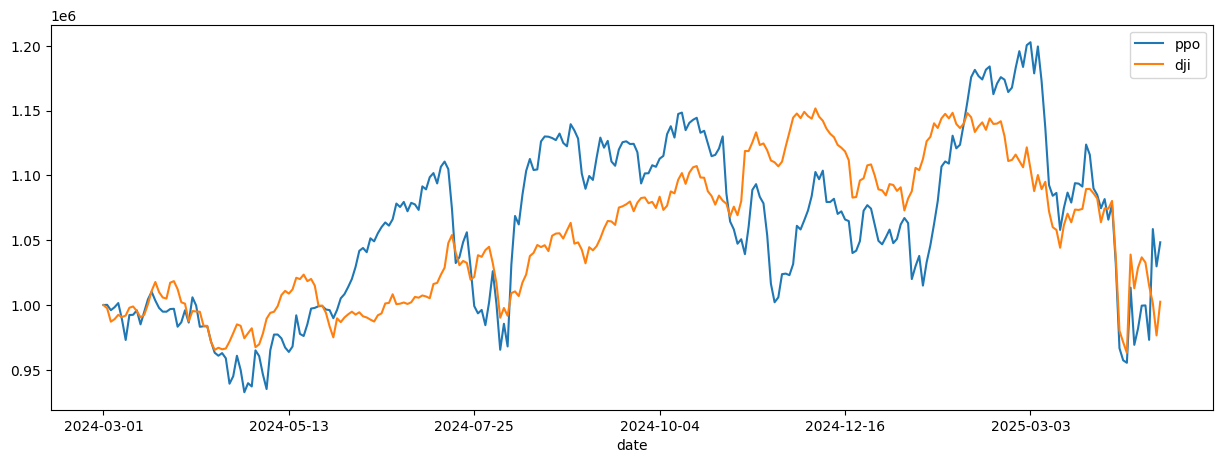

In [127]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.show()

### A2C

In [280]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {
    "n_steps": 10,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
}
model_a2c = agent.get_model("a2c", model_kwargs = A2C_PARAMS)

if if_using_a2c:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0001}
Using cuda device
Logging to results/a2c


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [281]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=100000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 498         |
|    iterations         | 100         |
|    time_elapsed       | 2           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -38.3       |
|    explained_variance | -0.123      |
|    learning_rate      | 0.0001      |
|    n_updates          | 99          |
|    policy_loss        | 146         |
|    reward             | -0.17746784 |
|    std                | 1           |
|    value_loss         | 17.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 500       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -38.3     |
|    explained_variance | -0.18     |
|    learning_rate

In [286]:
trained_a2c.save(config.TRAINED_MODEL_DIR + "/agent_a2c_sentiment") if if_using_a2c else None

Trading

In [282]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [283]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)

hit end!


In [284]:
df_account_value.tail()

,date,account_value
281,2025-04-15,1.101377e+06
282,2025-04-16,1.080355e+06
283,2025-04-17,1.147310e+06
284,2025-04-21,1.112383e+06
285,2025-04-22,1.133601e+06


Backtesting Performance

In [285]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.116827
Cumulative returns     0.133601
Annual volatility      0.213464
Sharpe ratio           0.625770
Calmar ratio           0.654776
Stability              0.491584
Max drawdown          -0.178423
Omega ratio            1.119843
Sortino ratio          0.904391
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.816585
Daily value at risk   -0.026364
dtype: float64


In [277]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


In [287]:
df_result_a2c = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"],
        "dji": dji["close"],
    }
)
result

,a2c,dji
date,,
2024-03-01,1.000000e+06,1.000000e+06
2024-03-04,1.000487e+06,9.975043e+05
2024-03-05,9.982146e+05,9.871522e+05
2024-03-06,9.997227e+05,9.890929e+05
2024-03-07,1.002611e+06,9.924265e+05
...,...,...
2025-04-15,1.101377e+06,1.032788e+06
2025-04-16,1.080355e+06,1.014890e+06
2025-04-17,1.147310e+06,1.001403e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

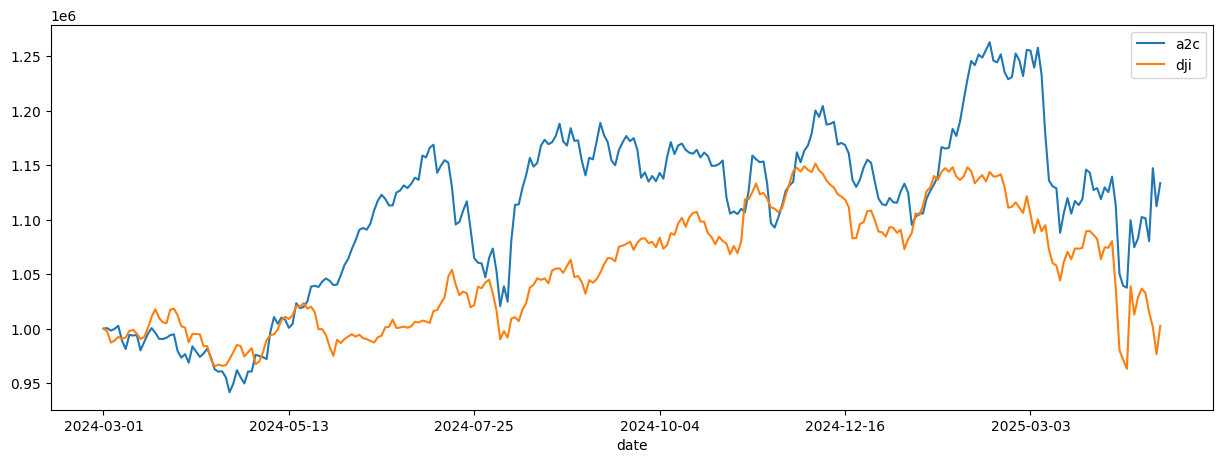

In [288]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

### TD3

In [226]:

agent = DRLAgent(env = env_train)
TD3_PARAMS = {
    "batch_size": 128,
    "buffer_size": 50000,
    "learning_rate": 0.001,
}
model_td3 = agent.get_model("td3", model_kwargs = TD3_PARAMS)
if if_using_td3:
  # set up logger
  tmp_path = config.RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [227]:
trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=50000) if if_using_td3 else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 234        |
|    time_elapsed    | 8          |
|    total_timesteps | 2008       |
| train/             |            |
|    actor_loss      | -6.23      |
|    critic_loss     | 6.13       |
|    learning_rate   | 0.001      |
|    n_updates       | 1907       |
|    reward          | 0.36469206 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 238        |
|    time_elapsed    | 16         |
|    total_timesteps | 4016       |
| train/             |            |
|    actor_loss      | -3.83      |
|    critic_loss     | 18.4       |
|    learning_rate   | 0.001      |
|    n_updates       | 3915       |
|    reward          | 0.36469206 |
-----------------------------------
day: 501, episode: 410
begin_total_asset: 1000000.00
end_total_a

In [228]:
trained_td3.save(config.TRAINED_MODEL_DIR + "/agent_td3_sentiment") if if_using_td3 else None

Trading

In [229]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [230]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym)

hit end!


In [231]:
df_account_value.tail()

,date,account_value
281,2025-04-15,1.050767e+06
282,2025-04-16,1.037090e+06
283,2025-04-17,1.009317e+06
284,2025-04-21,9.820846e+05
285,2025-04-22,1.007438e+06


Backtesting Performance

In [232]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')


==============Get Backtest Results===========
Annual return          0.006551
Cumulative returns     0.007438
Annual volatility      0.185863
Sharpe ratio           0.127711
Calmar ratio           0.034562
Stability              0.570800
Max drawdown          -0.189542
Omega ratio            1.024070
Sortino ratio          0.176987
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.720140
Daily value at risk   -0.023322
dtype: float64


In [233]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


In [234]:
df_result_td3 = df_account_value.set_index(df_account_value.columns[0])
result = pd.DataFrame(
    {
        "td3": df_result_td3["account_value"],
        "dji": dji["close"],
    }
)

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

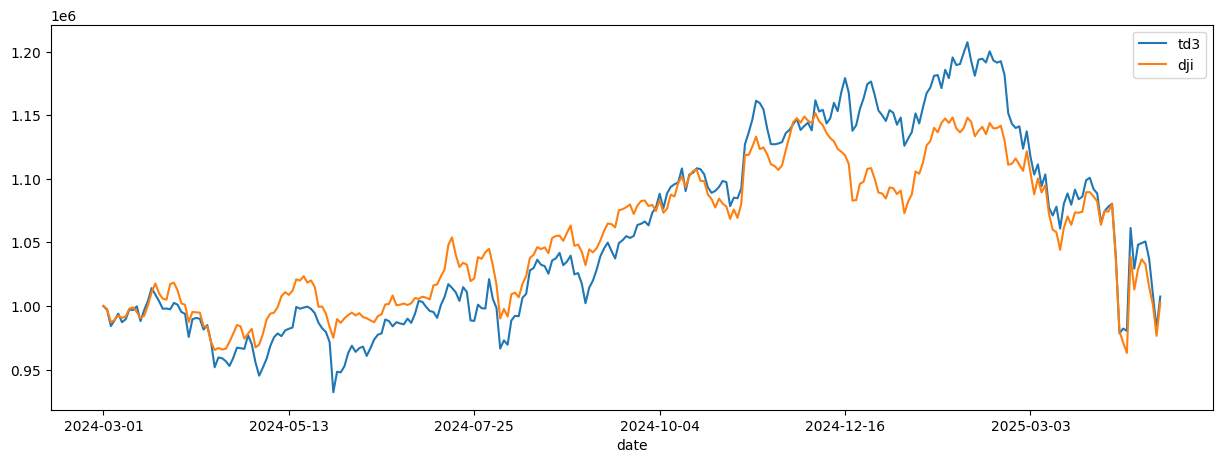

In [235]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()